In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reading the data
exp_name = "NNR52DmZ"             # 0zLGpNUa     LZZkuGAZ   ibZ5x3E5  RGBS_p00     RGBSLANSHEGLA_p00_cleaned  t7Hiwh6A(2000+ boxes)   kzHjKthT (200+ boxes) ME0X3ynk aE4pm07D 8FU3FYuL 8asQEA6P (best so far) n8djAKPf

test_scores_path = f"/lustre_scratch/shaerdan/scores/test_scores_{exp_name}.nc"

ds_test = xr.open_dataset(test_scores_path)

print(ds_test)

# variable names
variable_names = list(ds_test.variables)
print("List of variable names:")
for var in variable_names:
    print(var)

save_plots_test = False


<xarray.Dataset>
Dimensions:                            (box: 8280, x: 100, y: 100, channel: 1, tasmax_chan: 1, y2: 10, x2: 10, land_cover_chan: 1, tasmin_chan: 1, rainfall_chan: 1, model_output_channel: 1, model_output_y: 100, model_output_x: 100)
Coordinates:
  * box                                (box) int64 0 1 2 3 ... 8277 8278 8279
  * x                                  (x) int64 0 1 2 3 4 5 ... 95 96 97 98 99
  * y                                  (y) int64 0 1 2 3 4 5 ... 95 96 97 98 99
  * channel                            (channel) int64 0
Dimensions without coordinates: tasmax_chan, y2, x2, land_cover_chan, tasmin_chan, rainfall_chan, model_output_channel, model_output_y, model_output_x
Data variables: (12/66)
    ST_slices                          (box, channel, y, x) float32 ...
    SW_corner_x                        (box) int32 ...
    SW_corner_y                        (box) int32 ...
    cloud_free_fractions               (box) float64 ...
    box_time                 

In [2]:
print(ds_test.land_cover_built[0].values)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [3]:
# standardize the data for comparison

prediction = ds_test.hires_estimate.isel(model_output_channel=0)
# predictor = ds_test.tasmax.isel(land_cover_chan=0)
predictor = ds_test.era5_skt.isel(channel=0)
ground_truth = ds_test.ST_slices.isel(channel=0)
# print(ground_truth)

ground_truth = ground_truth.drop_vars([coord for coord in ground_truth.coords if coord not in prediction.dims])
ground_truth.attrs.pop('units', None)
ground_truth.attrs.pop('standard_name', None)
# print(predictor.coords)
predictor = predictor.drop_vars([coord for coord in predictor.coords])
prediction = prediction.rename({'model_output_y': 'y', 'model_output_x': 'x'})

print(predictor)
print(prediction)
print(ground_truth)




<xarray.DataArray 'era5_skt' (box: 8280, y: 100, x: 100)>
[82800000 values with dtype=float32]
Dimensions without coordinates: box, y, x
<xarray.DataArray 'hires_estimate' (box: 8280, y: 100, x: 100)>
[82800000 values with dtype=float64]
Coordinates:
  * box      (box) int64 0 1 2 3 4 5 6 7 ... 8273 8274 8275 8276 8277 8278 8279
Dimensions without coordinates: y, x
<xarray.DataArray 'ST_slices' (box: 8280, y: 100, x: 100)>
[82800000 values with dtype=float32]
Coordinates:
  * box      (box) int64 0 1 2 3 4 5 6 7 ... 8273 8274 8275 8276 8277 8278 8279
Dimensions without coordinates: y, x


In [4]:

predictor = predictor.assign_coords(box_time=ds_test.box_time)
prediction = prediction.assign_coords(box_time=ds_test.box_time)
ground_truth = ground_truth.assign_coords(box_time=ds_test.box_time)

prediction_by_month = prediction.groupby('box_time.month')
ground_truth_by_month = ground_truth.groupby('box_time.month')

january_indices = prediction_by_month.groups[1]

prediction_january = prediction.sel(box=january_indices)
ground_truth_january = ground_truth.sel(box=january_indices)

print(prediction_january)
print(ground_truth_january)


<xarray.DataArray 'hires_estimate' (box: 178, y: 100, x: 100)>
[1780000 values with dtype=float64]
Coordinates:
  * box       (box) int64 103 154 155 166 167 205 ... 7757 7840 8045 8102 8236
    box_time  (box) datetime64[ns] 2021-01-31T11:21:50 ... 2022-01-22T10:58:21
Dimensions without coordinates: y, x
<xarray.DataArray 'ST_slices' (box: 178, y: 100, x: 100)>
[1780000 values with dtype=float32]
Coordinates:
  * box       (box) int64 103 154 155 166 167 205 ... 7757 7840 8045 8102 8236
    box_time  (box) datetime64[ns] 2021-01-31T11:21:50 ... 2022-01-22T10:58:21
Dimensions without coordinates: y, x


In [5]:
import xarray as xr
import numpy as np
import pandas as pd

# Assuming ds_test is already loaded as in your script
# ds_test = xr.open_dataset(...)

# Extract the prediction and ground truth
prediction = ds_test.hires_estimate.isel(model_output_channel=0)
ground_truth = ds_test.ST_slices.isel(channel=0)

# Drop coordinates from ground_truth that are not in prediction
ground_truth = ground_truth.drop_vars([coord for coord in ground_truth.coords if coord not in prediction.dims])
ground_truth.attrs.pop('units', None)
ground_truth.attrs.pop('standard_name', None)
prediction = prediction.rename({'model_output_y': 'y', 'model_output_x': 'x'})

# Ensure that prediction and ground_truth have the same shape
assert prediction.shape == ground_truth.shape, "Shapes of prediction and ground_truth do not match"

# Compute RMSE for each box
rmse = np.sqrt(((prediction - ground_truth) ** 2).mean(dim=['y', 'x']))

# Assuming x_eastings and y_northings are coordinates in ds_test and are 2D arrays with shape (4630, 100)
x_eastings = ds_test.x_eastings.values
y_northings = ds_test.y_northings.values
print(x_eastings.shape)
print(y_northings.shape)

# Define the bin size in meters (same as your original bin size)
sz = 10000

# Calculate the center coordinates for each box
x_centers = np.round((x_eastings[:, 0] + 5000) / sz) * sz
y_centers = np.round((y_northings[:, -1] + 5000) / sz) * sz
print(x_centers.shape)
print(y_centers.shape)

# Combine RMSE with center coordinates into a DataFrame
rmse_df = pd.DataFrame({
    'x_centers': x_centers,
    'y_centers': y_centers,
    'rmse': rmse.values
})

# Group by x_centers and y_centers and calculate the mean RMSE
mean_rmse_df = rmse_df.groupby(['x_centers', 'y_centers'])['rmse'].mean().reset_index()

# Convert back to xarray Dataset if needed
mean_rmse = mean_rmse_df.set_index(['x_centers', 'y_centers']).to_xarray()

print(mean_rmse_df)


(8280, 100)
(8280, 100)
(8280,)
(8280,)
     x_centers  y_centers      rmse
0      10000.0   530000.0  2.017374
1      20000.0   530000.0  2.095188
2      30000.0   530000.0  1.453293
3      40000.0   510000.0  1.810803
4      40000.0   520000.0  1.832613
..         ...        ...       ...
704   610000.0   300000.0  2.351012
705   620000.0   270000.0  2.488728
706   620000.0   280000.0  2.532438
707   620000.0   290000.0  2.819864
708   620000.0   300000.0  2.825784

[709 rows x 3 columns]


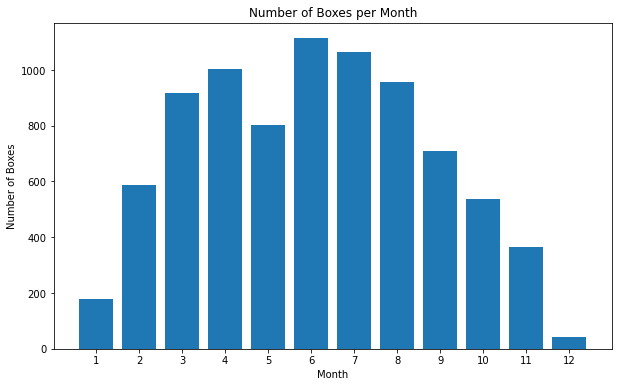

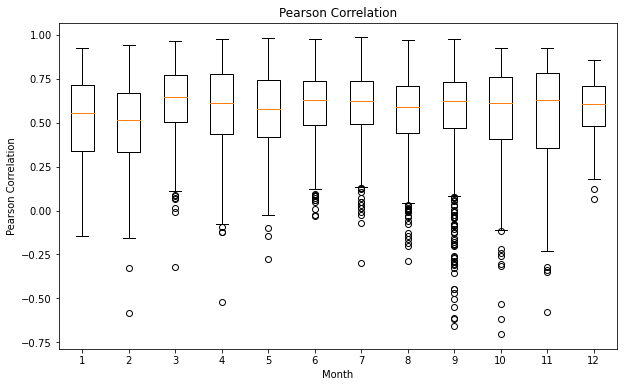

Month 2 outliers:
2017-02-14T11:15:51.000000000
2021-02-18T11:10:12.000000000
Month 3 outliers:
2016-03-03T10:51:53.000000000
2017-03-13T10:57:55.000000000
2022-03-19T10:58:10.000000000
2021-03-31T11:03:44.000000000
2022-03-11T10:58:08.000000000
2018-03-30T11:09:12.000000000
2014-03-19T11:10:35.000000000
Month 4 outliers:
2013-04-12T10:53:46.000000000
2019-04-20T10:57:36.000000000
2019-04-20T10:57:12.000000000
2013-04-28T10:54:09.000000000
Month 5 outliers:
2019-05-15T10:51:34.000000000
2022-05-06T10:57:52.000000000
2022-05-06T10:57:52.000000000
Month 6 outliers:
2020-06-25T10:57:54.000000000
2013-06-06T11:00:12.000000000
2022-06-21T11:09:55.000000000
2013-06-06T11:00:36.000000000
2022-06-15T10:58:45.000000000
2022-06-15T10:58:45.000000000
2016-06-03T11:15:35.000000000
2016-06-05T11:03:38.000000000
2016-06-05T11:03:38.000000000
2022-06-23T10:58:01.000000000
2013-06-27T11:17:28.000000000
2014-06-23T11:09:51.000000000
Month 7 outliers:
2014-07-25T11:10:25.000000000
2022-07-16T11:04:34.00

In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def pearson_correlation(pred, true):
    pred_flat = pred.stack(z=['y', 'x'])
    true_flat = true.stack(z=['y', 'x'])
    
    pred_mean = pred_flat.mean(dim='z')
    true_mean = true_flat.mean(dim='z')
    
    pred_anomaly = pred_flat - pred_mean
    true_anomaly = true_flat - true_mean
    
    covariance = (pred_anomaly * true_anomaly).mean(dim='z')
    pred_std = pred_anomaly.std(dim='z')
    true_std = true_anomaly.std(dim='z')
    
    correlation = covariance / (pred_std * true_std)
    return correlation

prediction = prediction.assign_coords(box_time=ds_test.box_time)
ground_truth = ground_truth.assign_coords(box_time=ds_test.box_time)

correlation_per_box = pearson_correlation(prediction, ground_truth)

correlation_per_box_by_month = correlation_per_box.groupby('box_time.month')

correlation_values_by_month = []
box_count_by_month = []
outlier_dates_by_month = {}

for month in range(1, 13):
    if month in correlation_per_box_by_month.groups:
        month_indices = correlation_per_box_by_month.groups[month]
        correlation_month = correlation_per_box.sel(box=month_indices)
        correlation_values_by_month.append(correlation_month.values)
        box_count_by_month.append(len(month_indices))
        
        if correlation_month.size > 0:
            # Identify outliers
            Q1 = np.percentile(correlation_month, 25)
            Q3 = np.percentile(correlation_month, 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = correlation_month.where((correlation_month < lower_bound) | (correlation_month > upper_bound), drop=True)
            if outliers.size > 0:
                # Filter the dates to include only those within the current month
                month_dates = prediction.sel(box=month_indices).box_time
                outlier_dates = month_dates.sel(box=outliers.box).values
                outlier_dates_by_month[month] = outlier_dates
    else:
        box_count_by_month.append(0)

# for month, count in zip(range(1, 13), box_count_by_month):
#     print(f"Month {month}: {count} boxes")
# print(f"Total number of boxes: {sum(box_count_by_month)}")

plt.figure(figsize=(10, 6))
plt.bar(range(1, 13), box_count_by_month, tick_label=[str(month) for month in range(1, 13)])
plt.xlabel('Month')
plt.ylabel('Number of Boxes')
plt.title('Number of Boxes per Month')
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(correlation_values_by_month, labels=[str(month) for month in range(1, 13) if month in correlation_per_box_by_month.groups])
plt.xlabel('Month')
plt.ylabel('Pearson Correlation')
plt.title('Pearson Correlation')
plt.show()

for month, dates in outlier_dates_by_month.items():
    print(f"Month {month} outliers:")
    for date in dates:
        print(date)

Month 1: 178 boxes
Month 2: 586 boxes
Month 3: 917 boxes
Month 4: 1004 boxes
Month 5: 803 boxes
Month 6: 1114 boxes
Month 7: 1065 boxes
Month 8: 958 boxes
Month 9: 710 boxes
Month 10: 539 boxes
Month 11: 365 boxes
Month 12: 41 boxes


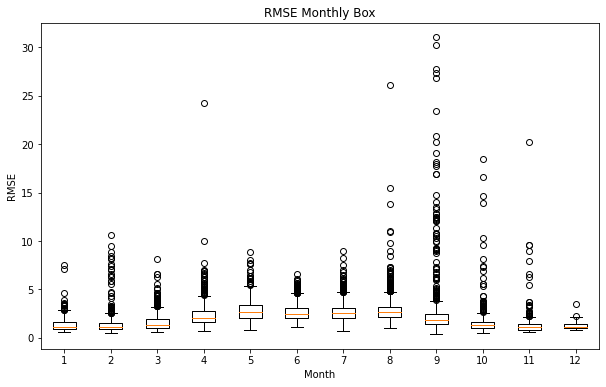

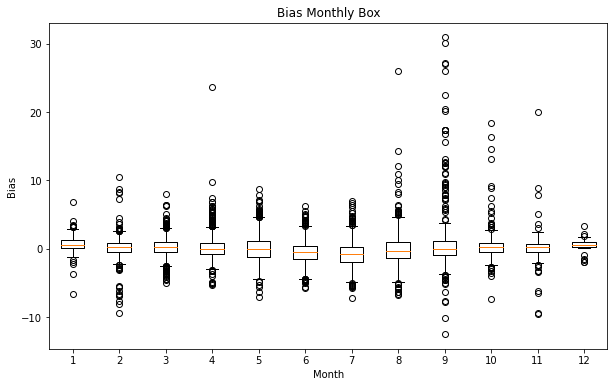

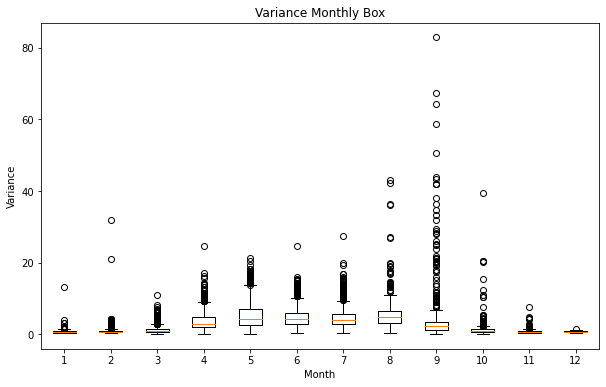

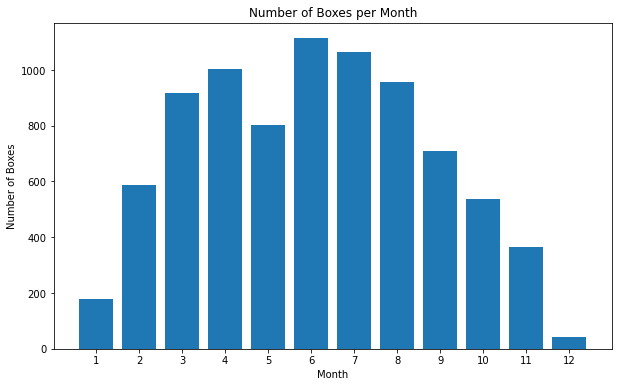

In [7]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Define functions to calculate bias and variance
def bias(pred, true):
    return (pred.mean(dim=['y', 'x']) - true.mean(dim=['y', 'x']))

def variance_of_errors(pred, true):
    return np.var(pred - true, axis=(1, 2))

def rmse(pred, true):
    return np.sqrt(((pred - true) ** 2).mean(dim=['y', 'x']))

# Ensure the predictions and ground truth have the same coordinates
prediction = prediction.assign_coords(box_time=ds_test.box_time)
ground_truth = ground_truth.assign_coords(box_time=ds_test.box_time)

# Calculate RMSE, Bias, and Variance
rmse_per_box = rmse(prediction, ground_truth)
bias_per_box = bias(prediction, ground_truth)
variance_per_box = variance_of_errors(prediction, ground_truth)

# Group by month
rmse_per_box_by_month = rmse_per_box.groupby('box_time.month')
bias_per_box_by_month = bias_per_box.groupby('box_time.month')
variance_per_box_by_month = variance_per_box.groupby('box_time.month')

rmse_values_by_month = []
bias_values_by_month = []
variance_values_by_month = []
box_count_by_month = []

for month in range(1, 13):
    if month in rmse_per_box_by_month.groups:
        month_indices = rmse_per_box_by_month.groups[month]
        
        rmse_month = rmse_per_box.sel(box=month_indices)
        bias_month = bias_per_box.sel(box=month_indices)
        variance_month = variance_per_box.sel(box=month_indices)
        
        rmse_values_by_month.append(rmse_month.values)
        bias_values_by_month.append(bias_month.values)
        variance_values_by_month.append(variance_month.values)
        
        box_count_by_month.append(len(month_indices))
    else:
        box_count_by_month.append(0)

for month, count in zip(range(1, 13), box_count_by_month):
    print(f"Month {month}: {count} boxes")

# Plot RMSE
plt.figure(figsize=(10, 6))
plt.boxplot(rmse_values_by_month, labels=[str(month) for month in range(1, 13) if month in rmse_per_box_by_month.groups])
plt.xlabel('Month')
plt.ylabel('RMSE')
plt.title('RMSE Monthly Box')
plt.show()

# Plot Bias
plt.figure(figsize=(10, 6))
plt.boxplot(bias_values_by_month, labels=[str(month) for month in range(1, 13) if month in bias_per_box_by_month.groups])
plt.xlabel('Month')
plt.ylabel('Bias')
plt.title('Bias Monthly Box')
plt.show()

# Plot Variance
plt.figure(figsize=(10, 6))
plt.boxplot(variance_values_by_month, labels=[str(month) for month in range(1, 13) if month in variance_per_box_by_month.groups])
plt.xlabel('Month')
plt.ylabel('Variance')
plt.title('Variance Monthly Box')
plt.show()

# Plot Number of Boxes per Month
plt.figure(figsize=(10, 6))
plt.bar(range(1, 13), box_count_by_month, tick_label=[str(month) for month in range(1, 13)])
plt.xlabel('Month')
plt.ylabel('Number of Boxes')
plt.title('Number of Boxes per Month')
plt.show()


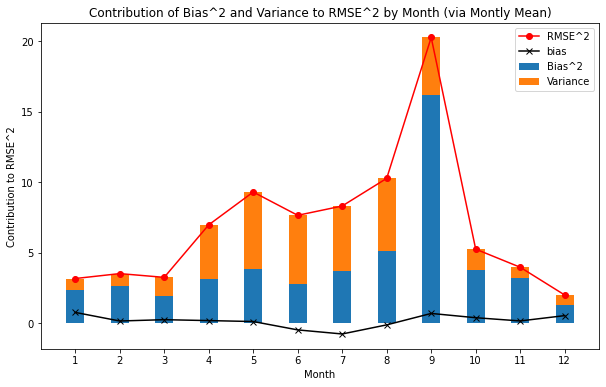

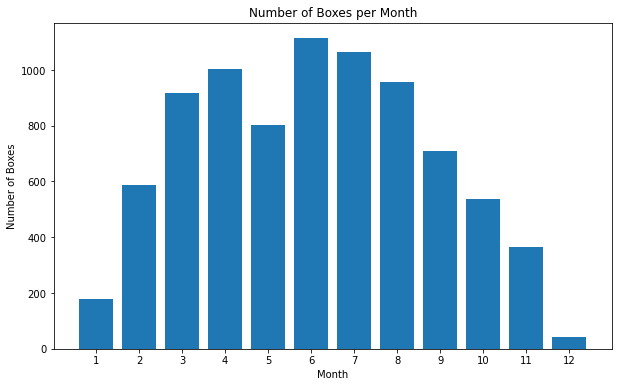

In [8]:
# Ensure the predictions and ground truth have the same coordinates
prediction = prediction.assign_coords(box_time=ds_test.box_time)
ground_truth = ground_truth.assign_coords(box_time=ds_test.box_time)

# Calculate RMSE, Bias, and Variance of Errors
rmse_per_box = rmse(prediction, ground_truth)
bias_per_box = bias(prediction, ground_truth)
variance_of_errors_per_box = variance_of_errors(prediction, ground_truth)

# Group by month
rmse_per_box_by_month = rmse_per_box.groupby('box_time.month')
bias_per_box_by_month = bias_per_box.groupby('box_time.month')
variance_of_errors_per_box_by_month = variance_of_errors_per_box.groupby('box_time.month')

rmse_values_by_month = []
bias_values_by_month = []
variance_values_by_month = []
box_count_by_month = []

for month in range(1, 13):
    if month in rmse_per_box_by_month.groups:
        month_indices = rmse_per_box_by_month.groups[month]
        
        rmse_month = rmse_per_box[month_indices]
        bias_month = bias_per_box[month_indices]
        variance_month = variance_of_errors_per_box[month_indices]
        
        rmse_values_by_month.append(rmse_month)
        bias_values_by_month.append(bias_month)
        variance_values_by_month.append(variance_month)
        
        box_count_by_month.append(len(month_indices))
    else:
        box_count_by_month.append(0)

# Compute bias squared and variance contribution
bias_squared_by_month = [np.mean(bias**2) for bias in bias_values_by_month]
bias_by_month = [np.mean(bias) for bias in bias_values_by_month]
variance_by_month = [np.mean(var) for var in variance_values_by_month]
rmse_squared_by_month = [np.mean(rmse**2) for rmse in rmse_values_by_month]

# Plot Stacked Bar Chart to show contribution of Bias^2 and Variance to RMSE^2
plt.figure(figsize=(10, 6))
width = 0.4
months = [str(month) for month in range(1, 13) if month in rmse_per_box_by_month.groups]

plt.bar(months, bias_squared_by_month, width, label='Bias^2')
plt.bar(months, variance_by_month, width, bottom=bias_squared_by_month, label='Variance')
plt.plot(months, rmse_squared_by_month, color='red', marker='o', label='RMSE^2')
plt.plot(months, bias_by_month,color='black', marker='x', label='bias')

plt.xlabel('Month')
plt.ylabel('Contribution to RMSE^2')
plt.title('Contribution of Bias^2 and Variance to RMSE^2 by Month (via Montly Mean)')
plt.legend()
plt.show()

# Plot Number of Boxes per Month
plt.figure(figsize=(10, 6))
plt.bar(range(1, 13), box_count_by_month, tick_label=[str(month) for month in range(1, 13)])
plt.xlabel('Month')
plt.ylabel('Number of Boxes')
plt.title('Number of Boxes per Month')
plt.show()


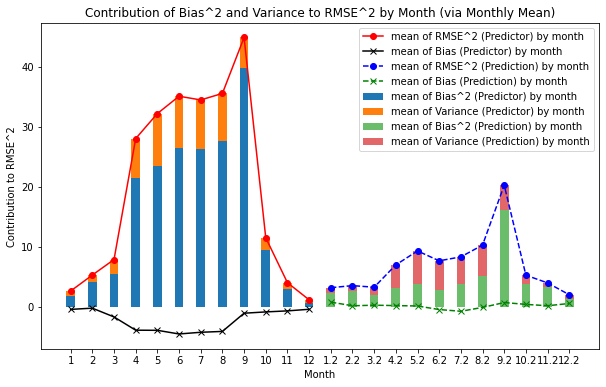

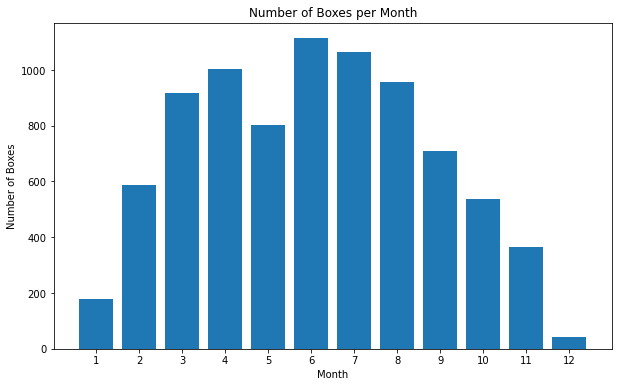

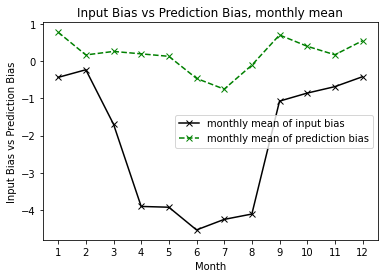

In [12]:

# Calculate RMSE, Bias, and Variance of Errors for predictor
rmse_predictor_per_box = rmse(predictor, ground_truth)
bias_predictor_per_box = bias(predictor, ground_truth)
variance_predictor_per_box = variance_of_errors(predictor, ground_truth)

# Calculate RMSE, Bias, and Variance of Errors for prediction
rmse_prediction_per_box = rmse(prediction, ground_truth)
bias_prediction_per_box = bias(prediction, ground_truth)
variance_prediction_per_box = variance_of_errors(prediction, ground_truth)

# Group by month for predictor
rmse_predictor_by_month = rmse_predictor_per_box.groupby('box_time.month')
bias_predictor_by_month = bias_predictor_per_box.groupby('box_time.month')
variance_predictor_by_month = variance_predictor_per_box.groupby('box_time.month')

# Group by month for prediction
rmse_prediction_by_month = rmse_prediction_per_box.groupby('box_time.month')
bias_prediction_by_month = bias_prediction_per_box.groupby('box_time.month')
variance_prediction_by_month = variance_prediction_per_box.groupby('box_time.month')

# Initialize lists to hold monthly stats for predictor
rmse_predictor_values_by_month = []
bias_predictor_values_by_month = []
variance_predictor_values_by_month = []
box_count_by_month = []

# Initialize lists to hold monthly stats for prediction
rmse_prediction_values_by_month = []
bias_prediction_values_by_month = []
variance_prediction_values_by_month = []

# Compute statistics by month
for month in range(1, 13):
    if month in rmse_predictor_by_month.groups:
        month_indices = rmse_predictor_by_month.groups[month]
        
        rmse_predictor_month = rmse_predictor_per_box[month_indices]
        bias_predictor_month = bias_predictor_per_box[month_indices]
        variance_predictor_month = variance_predictor_per_box[month_indices]
        
        rmse_predictor_values_by_month.append(rmse_predictor_month)
        bias_predictor_values_by_month.append(bias_predictor_month)
        variance_predictor_values_by_month.append(variance_predictor_month)
        
        rmse_prediction_month = rmse_prediction_per_box[month_indices]
        bias_prediction_month = bias_prediction_per_box[month_indices]
        variance_prediction_month = variance_prediction_per_box[month_indices]
        
        rmse_prediction_values_by_month.append(rmse_prediction_month)
        bias_prediction_values_by_month.append(bias_prediction_month)
        variance_prediction_values_by_month.append(variance_prediction_month)
        
        box_count_by_month.append(len(month_indices))
    else:
        box_count_by_month.append(0)

# Compute bias squared and variance contribution for predictor
bias_squared_predictor_by_month = [np.mean(bias**2) for bias in bias_predictor_values_by_month]
bias_predictor_by_month = [np.mean(bias) for bias in bias_predictor_values_by_month]
variance_predictor_by_month = [np.mean(var) for var in variance_predictor_values_by_month]
rmse_squared_predictor_by_month = [np.mean(rmse**2) for rmse in rmse_predictor_values_by_month]

# Compute bias squared and variance contribution for prediction
bias_squared_prediction_by_month = [np.mean(bias**2) for bias in bias_prediction_values_by_month]
bias_prediction_by_month = [np.mean(bias) for bias in bias_prediction_values_by_month]
variance_prediction_by_month = [np.mean(var) for var in variance_prediction_values_by_month]
rmse_squared_prediction_by_month = [np.mean(rmse**2) for rmse in rmse_prediction_values_by_month]

months = [str(month) for month in range(1, 13) if month in rmse_predictor_by_month.groups]

# Plot Stacked Bar Chart to show contribution of Bias^2 and Variance to RMSE^2 for both prediction and predictor
plt.figure(figsize=(10, 6))
width = 0.4

# Plot for predictor
plt.bar(months, bias_squared_predictor_by_month, width, label='mean of Bias^2 (Predictor) by month')
plt.bar(months, variance_predictor_by_month, width, bottom=bias_squared_predictor_by_month, label='mean of Variance (Predictor) by month')
plt.plot(months, rmse_squared_predictor_by_month, color='red', marker='o', label='mean of RMSE^2 (Predictor) by month')
plt.plot(months, bias_predictor_by_month, color='black', marker='x', label='mean of Bias (Predictor) by month')

# Plot for prediction with offset
months_offset = [str(int(month) + 0.2) for month in months]
plt.bar(months_offset, bias_squared_prediction_by_month, width, label='mean of Bias^2 (Prediction) by month', alpha=0.7)
plt.bar(months_offset, variance_prediction_by_month, width, bottom=bias_squared_prediction_by_month, label='mean of Variance (Prediction) by month', alpha=0.7)
plt.plot(months_offset, rmse_squared_prediction_by_month, color='blue', marker='o', linestyle='dashed', label='mean of RMSE^2 (Prediction) by month')
plt.plot(months_offset, bias_prediction_by_month, color='green', marker='x', linestyle='dashed', label='mean of Bias (Prediction) by month')

plt.xlabel('Month')
plt.ylabel('Contribution to RMSE^2')
plt.title('Contribution of Bias^2 and Variance to RMSE^2 by Month (via Monthly Mean)')
plt.legend()
plt.show()

# Plot Number of Boxes per Month
plt.figure(figsize=(10, 6))
plt.bar(range(1, 13), box_count_by_month, tick_label=[str(month) for month in range(1, 13)])
plt.xlabel('Month')
plt.ylabel('Number of Boxes')
plt.title('Number of Boxes per Month')
plt.show()

plt.plot(months, bias_predictor_by_month, color='black', marker='x', label='monthly mean of input bias ')
plt.plot(months, bias_prediction_by_month, color='green', marker='x', linestyle='dashed', label='monthly mean of prediction bias')
plt.xlabel('Month')
plt.ylabel('Input Bias vs Prediction Bias')
plt.title('Input Bias vs Prediction Bias, monthly mean')
plt.legend()
plt.show()


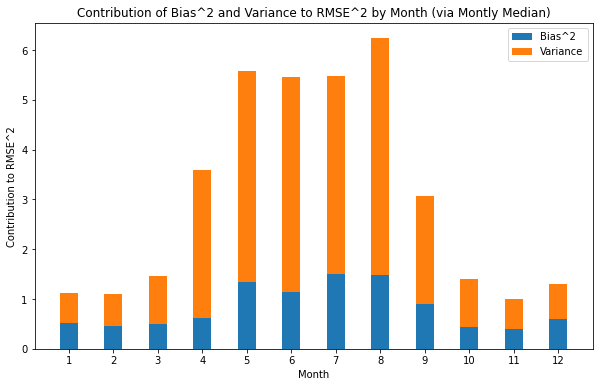

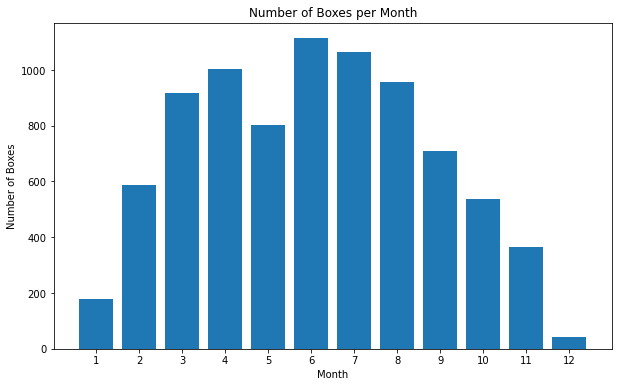

In [10]:
bias_squared_by_month = [np.median(bias**2) for bias in bias_values_by_month]
variance_by_month = [np.median(var) for var in variance_values_by_month]


# Plot Stacked Bar Chart to show contribution of Bias^2 and Variance to RMSE^2
plt.figure(figsize=(10, 6))
width = 0.4
months = [str(month) for month in range(1, 13) if month in rmse_per_box_by_month.groups]

plt.bar(months, bias_squared_by_month, width, label='Bias^2')
plt.bar(months, variance_by_month, width, bottom=bias_squared_by_month, label='Variance')

plt.xlabel('Month')
plt.ylabel('Contribution to RMSE^2')
plt.title('Contribution of Bias^2 and Variance to RMSE^2 by Month (via Montly Median)')
plt.legend()
plt.show()

# Plot Number of Boxes per Month
plt.figure(figsize=(10, 6))
plt.bar(range(1, 13), box_count_by_month, tick_label=[str(month) for month in range(1, 13)])
plt.xlabel('Month')
plt.ylabel('Number of Boxes')
plt.title('Number of Boxes per Month')
plt.show()

In [11]:
import pandas as pd

# Outlier identification and printing
rmse_outliers = {}
bias_outliers = {}
variance_outliers = {}

outlier_data = []

for month in range(1, 13):
    if month in rmse_per_box_by_month.groups:
        month_indices = np.array(rmse_per_box_by_month.groups[month])  # Convert to numpy array
        
        rmse_month = rmse_per_box.sel(box=month_indices)
        bias_month = bias_per_box.sel(box=month_indices)
        variance_month = variance_per_box.sel(box=month_indices)
        
        # Identify outliers for RMSE
        q1_rmse, q3_rmse = np.percentile(rmse_month.values, [25, 75])
        iqr_rmse = q3_rmse - q1_rmse
        rmse_mask = (rmse_month.values < (q1_rmse - 1.5 * iqr_rmse)) | (rmse_month.values > (q3_rmse + 1.5 * iqr_rmse))
        rmse_outlier_indices = month_indices[np.where(rmse_mask)[0]]
        rmse_outliers[month] = rmse_outlier_indices

        # Identify outliers for Bias
        q1_bias, q3_bias = np.percentile(bias_month.values, [25, 75])
        iqr_bias = q3_bias - q1_bias
        bias_mask = (bias_month.values < (q1_bias - 1.5 * iqr_bias)) | (bias_month.values > (q3_bias + 1.5 * iqr_bias))
        bias_outlier_indices = month_indices[np.where(bias_mask)[0]]
        bias_outliers[month] = bias_outlier_indices

        # Identify outliers for Variance
        q1_var, q3_var = np.percentile(variance_month.values, [25, 75])
        iqr_var = q3_var - q1_var
        variance_mask = (variance_month.values < (q1_var - 1.5 * iqr_var)) | (variance_month.values > (q3_var + 1.5 * iqr_var))
        variance_outlier_indices = month_indices[np.where(variance_mask)[0]]
        variance_outliers[month] = variance_outlier_indices

        # Collect outlier data for saving to CSV
        for outlier_indices, outlier_type in zip([rmse_outlier_indices, bias_outlier_indices, variance_outlier_indices], ['RMSE', 'Bias', 'Variance']):
            for index in outlier_indices:
                outlier_data.append({
                    'Month': month,
                    'Outlier_Type': outlier_type,
                    'Box_Index': index,
                    'Box_Time': ds_test.box_time.sel(box=index).values,
                    'SW_Corner_X': ds_test.SW_corner_x.sel(box=index).values,
                    'SW_Corner_Y': ds_test.SW_corner_y.sel(box=index).values,
                    'Value': rmse_per_box.sel(box=index).values if outlier_type == 'RMSE' else bias_per_box.sel(box=index).values if outlier_type == 'Bias' else variance_per_box.sel(box=index).values
                })

# Convert to DataFrame and save to CSV
outlier_df = pd.DataFrame(outlier_data)
outlier_df.to_csv('outliers.csv', index=False)

# Print outliers for RMSE, Bias, and Variance
for month in range(1, 13):
    if month in rmse_outliers and len(rmse_outliers[month]) > 0:
        print(f"Month {month} RMSE outliers indices: {rmse_outliers[month]}")
        rmse_outlier_times = ds_test.box_time.sel(box=rmse_outliers[month]).values
        print(f"Month {month} RMSE outliers box_time: {rmse_outlier_times}")
        print(f"Month {month} RMSE outliers box indices: {rmse_outliers[month]}")
        rmse_outlier_values = rmse_per_box.sel(box=rmse_outliers[month]).values
        print(f"Month {month} RMSE outliers values: {rmse_outlier_values}")
    if month in bias_outliers and len(bias_outliers[month]) > 0:
        print(f"Month {month} Bias outliers indices: {bias_outliers[month]}")
        bias_outlier_times = ds_test.box_time.sel(box=bias_outliers[month]).values
        print(f"Month {month} Bias outliers box_time: {bias_outlier_times}")
        print(f"Month {month} Bias outliers box indices: {bias_outliers[month]}")
        bias_outlier_values = bias_per_box.sel(box=bias_outliers[month]).values
        print(f"Month {month} Bias outliers values: {bias_outlier_values}")
    if month in variance_outliers and len(variance_outliers[month]) > 0:
        print(f"Month {month} Variance outliers indices: {variance_outliers[month]}")
        variance_outlier_times = ds_test.box_time.sel(box=variance_outliers[month]).values
        print(f"Month {month} Variance outliers box_time: {variance_outlier_times}")
        print(f"Month {month} Variance outliers box indices: {variance_outliers[month]}")
        variance_outlier_values = variance_per_box.sel(box=variance_outliers[month]).values
        print(f"Month {month} Variance outliers values: {variance_outlier_values}")


Month 1 RMSE outliers indices: [ 103  310 1181 2309 3477 4622 4624 4625 5484 5485 6128 6131 6133 7393
 7520 7530]
Month 1 RMSE outliers box_time: ['2021-01-31T11:21:50.000000000' '2016-01-29T11:04:01.000000000'
 '2015-01-03T10:59:00.000000000' '2016-01-15T10:52:04.000000000'
 '2020-01-24T11:04:05.000000000' '2016-01-20T11:11:01.000000000'
 '2016-01-20T11:11:01.000000000' '2016-01-20T11:11:01.000000000'
 '2016-01-20T11:11:01.000000000' '2016-01-20T11:11:01.000000000'
 '2021-01-22T11:28:49.000000000' '2021-01-22T11:28:49.000000000'
 '2021-01-22T11:28:49.000000000' '2016-01-20T11:11:01.000000000'
 '2022-01-04T11:11:10.000000000' '2022-01-13T11:04:59.000000000']
Month 1 RMSE outliers box indices: [ 103  310 1181 2309 3477 4622 4624 4625 5484 5485 6128 6131 6133 7393
 7520 7530]
Month 1 RMSE outliers values: [7.52738732 3.85985893 7.11697615 3.08288276 2.9103046  3.4959662
 3.54725261 3.35563969 3.48439477 2.95827069 3.06640219 3.29190525
 2.99932216 3.40479742 4.57395057 2.91619314]
Month 